In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.stats import norm

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from src.utils.constants import *
from src.utils.functions import *
from src.utils.CosmoFunc import *

pvhub_dir = os.environ.get('PVHUB_DIR_PATH')
if not pvhub_dir in sys.path: sys.path.append(pvhub_dir)
from pvhub import * # type: ignore

def bin_data_rolling(x: np.array, y: np.array, n_bin: int, window_size: float):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(0.00475, 0.05377, n_bin)

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_bin:
        x_lower = x_trial - window_size
        x_upper = x_trial + window_size

        y_ = y[(x >= x_lower) & (x <= x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return x_bin_, y_bin, y_bin_err, y_bin_stderr

def bin_data(x: np.array, y: np.array, xmin: float, xmax: float, n_bin: int):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(xmin, xmax, n_bin)
    x_middle = 0.5 * (x_bin[1:] + x_bin[:-1])
    delta_x = np.diff(x_bin)[0]

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_middle:
        x_lower = x_trial - 0.5 * delta_x 
        x_upper = x_trial + 0.5 * delta_x

        y_ = y[(x >= x_lower) & (x < x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return np.array(x_bin_), np.array(y_bin), np.array(y_bin_err), np.array(y_bin_stderr)

r-band magnitude corresponding to J-band magnitude of 13.65 = 15.53
Number of galaxies with 2MASS counterpart in this new magnitude-limited sample =  4961


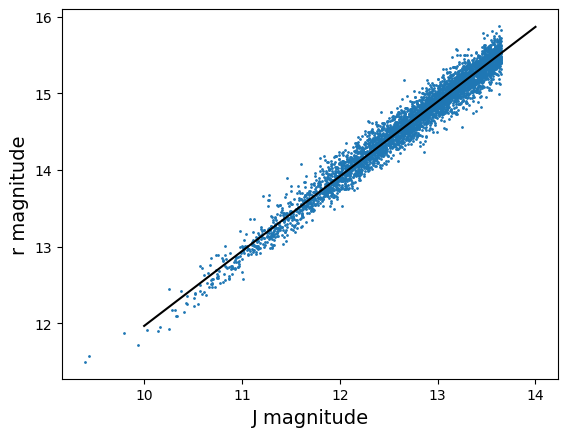

In [2]:
# Create linear function
def linear_func(x: np.array, m: float, c: float):
    return m * x + c

# Load Cullan's data
df_h22 = pd.read_csv("../../data/external/logdist/SDSS_PV_public.dat", delim_whitespace=True)

# Apply the same redshift cut as mine and add 'SDSS' prefix
df_h22 = df_h22[(df_h22["zcmb_group"] >= ZMIN) & (df_h22["zcmb_group"] <= ZMAX)]
df_h22["objid"] = df_h22["objid"].apply(lambda x: "SDSS" + str(x))

# Load my SDSS
df_sdss = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")[["objid", "j_m_ext", "extinction_j"]]

# Merge Cullan's SDSS and mine
df = df_h22.merge(df_sdss, on="objid", how="left")

# Add flag column for rows with 2MASS counterpart
df["has_counterpart"] = ~df["j_m_ext"].isna()

# Calculate extinction-corrected magnitudes
df["mag_r"] = df["deVMag_r"] - df["extinction_r"]
df["mag_j"] = df["j_m_ext"] - df["extinction_j"]

# Fit a linear curve
df_ = df.copy()
df_ = df_[df_["has_counterpart"] == True]
popt, pcov = curve_fit(linear_func, df_["mag_j"].to_numpy(), df_["mag_r"].to_numpy(), p0=[1.0, -2.0])

# Plot r vs J magnitude
plt.scatter(df_["mag_j"], df_["mag_r"], s=1)
plt.xlabel("J magnitude", fontsize=14)
plt.ylabel("r magnitude", fontsize=14)

# Plot the relation
x_ = np.linspace(10, 14, 100)
y_ = linear_func(x_, *popt)
plt.plot(x_, y_, c='k')

# Calculate r magnitude at J magnitude of 13.65
r_mag_lim = linear_func(13.65, *popt)
print(f"r-band magnitude corresponding to J-band magnitude of 13.65 = {round(r_mag_lim, 2)}")

# Select galaxies with that limiting r-magnitude (add new flag)
df["new_sample"] = (df["deVMag_r"] - df["extinction_r"]) <= r_mag_lim

print("Number of galaxies with 2MASS counterpart in this new magnitude-limited sample = ", df["new_sample"].sum())

# Save the data
df.to_csv("./cullan_sdss_processed.csv", index=False)

In [3]:
def fit_FP(
    df: pd.DataFrame,
    smin: float = np.log10(70),
    param_boundaries: List[Tuple] = [(0.8, 1.5), (-1.0, -0.7), (-0.2, 0.4), (2.0, 2.5), (2.5, 3.0), (0.04, 0.1), (0.3, 0.5), (0.15, 0.25)],
    pvals_cut: float = 0.01,
    zmin: float = 0.0033,
    zmax: float = ZMAX,
    solar_magnitude: float = 4.65,
    mag_high: float = 17.0,
    mag_low: float = 10.0,
    reject_outliers: bool = False,
    use_full_fn: bool = True
          ) -> Tuple[np.ndarray, pd.DataFrame]:

    # Load peculiar velocity model
    pv_model = TwoMPP_SDSS_6dF(verbose=True) # type: ignore

    # Calculate predicted PVs using observed group redshift in CMB frame, and calculate cosmological redshift
    df['v_pec'] = pv_model.calculate_pv(df['ra'].to_numpy(), df['dec'].to_numpy(), df['z_dist_est'].to_numpy())
    df['z_pec'] = df['v_pec'] / LIGHTSPEED
    df['z_cosmo'] = ((1 + df['z_dist_est']) / (1 + df['z_pec'])) - 1
    
    # Calculate predicted true distance and FN integral limits
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    d_H = sp.interpolate.splev(df['z_cosmo'].to_numpy(), dist_spline, der=0)
    df['lmin'] = (solar_magnitude + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_r"].to_numpy() + df["extinction_r"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_high) / 5.0
    df['lmax'] = (solar_magnitude + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_r"].to_numpy() + df["extinction_r"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_low) / 5.0

    # Calculate predicted logdistance-ratios
    d_z = sp.interpolate.splev(df['z_dist_est'].to_numpy(), dist_spline, der=0)
    df['logdist_pred'] = np.log10(d_z / d_H)
    df['r_true'] = df['r']# - df['logdist_pred']

    # If using partial f_n, calculate Sn using the VMAX method
    if not use_full_fn:
        # Get some redshift-distance lookup tables
        red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
        # The comoving distance to each galaxy using group redshift as distance indicator
        dz = sp.interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline, der=0)

        # (1+z) factor because we use luminosity distance
        Vmin = (1.0 + zmin)**3 * sp.interpolate.splev(zmin, dist_spline)**3
        Vmax = (1.0 + zmax)**3 * sp.interpolate.splev(zmax, dist_spline)**3
        # Maximum (luminosity) distance the galaxy can be observed given MAG_HIGH (survey limiting magnitude)
        Dlim = 10.0**((mag_high - (df["deVMag_r"] - df['extinction_r']) + 5.0 * np.log10(dz) + 5.0 * np.log10(1.0 + df["zhelio"])) / 5.0)    
        # Find the corresponding maximum redshift
        zlim = sp.interpolate.splev(Dlim, lumred_spline)
        Sn = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin)))
        df['Sn'] = Sn
    # If using full f_n, set Sn=1 for all galaxies
    else:
        Sn = 1.0
        df['Sn'] = Sn

    # Fitting the FP iteratively by rejecting galaxies with high chi-square (low p-values) in each iteration
    data_fit = df
    badcount = len(df)
    is_converged = False
    i = 1
    
    while not is_converged:

        Snfit = data_fit["Sn"].to_numpy()

        # The range of the FP parameters' values
        avals, bvals = param_boundaries[0], param_boundaries[1]
        rvals, svals, ivals = param_boundaries[2], param_boundaries[3], param_boundaries[4]
        s1vals, s2vals, s3vals = param_boundaries[5], param_boundaries[6], param_boundaries[7]

        # Fit the FP parameters
        FPparams = sp.optimize.differential_evolution(FP_func, bounds=(avals, bvals, rvals, svals, ivals, s1vals, s2vals, s3vals), 
            args=(0.0, data_fit["z_cmb"].to_numpy(), data_fit["r_true"].to_numpy(), data_fit["s"].to_numpy(), data_fit["i"].to_numpy(), data_fit["er"].to_numpy(), data_fit["es"].to_numpy(), data_fit["ei"].to_numpy(), Snfit, smin, data_fit["lmin"].to_numpy(), data_fit["lmax"].to_numpy(), data_fit["C_m"].to_numpy(), True, False, use_full_fn), maxiter=10000, tol=1.0e-6, workers=-1, seed=42)
        
        # Break from the loop if reject_outliers is set to false
        if reject_outliers == False:
            break
        
        # Calculate the chi-squared 
        chi_squared = Sn * FP_func(FPparams.x, 0.0, df["z_cmb"].to_numpy(), df["r_true"].to_numpy(), df["s"].to_numpy(), df["i"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), Sn, smin, df["lmin"].to_numpy(), df["lmax"].to_numpy(), df["C_m"].to_numpy(), sumgals=False, chi_squared_only=True)[0]
        
        # Calculate the p-value (x,dof)
        pvals = sp.stats.chi2.sf(chi_squared, np.sum(chi_squared)/(len(df) - 8.0))
        
        # Reject galaxies with p-values < pvals_cut (probabilities of being part of the sample lower than some threshold)
        data_fit = df.drop(df[pvals < pvals_cut].index).reset_index(drop=True)
        
        # Count the number of rejected galaxies
        badcountnew = len(np.where(pvals < pvals_cut)[0])
        
        # Converged if the number of rejected galaxies in this iteration is the same as previous iteration
        is_converged = True if badcount == badcountnew else False
        
        # Set the new count of rejected galaxies
        badcount = badcountnew
        i += 1

    df = data_fit
    
    return FPparams.x, df


def fit_logdist(
        df: pd.DataFrame,
        smin: float,
        FPlabel: str,
        FPparams: np.ndarray,
        use_full_fn: bool = True,
        mag_high: float = MAG_HIGH,
        mag_low: float = MAG_LOW,
        save_posterior: bool = False
    ) -> pd.DataFrame:
    """
    This is a function to calculate the log-distance ratio posteriors and obtain summary statistics.
    Summary statistics are obtained using two methods: direct calculation assuming skew-normal and 
    fitting using scipy's curve_fit assuming Gaussian.
    """

    # Get some redshift-distance lookup tables
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    dz = sp.interpolate.splev(df["z_cmb"].to_numpy() / LightSpeed, dist_spline)
    dz_cluster = sp.interpolate.splev(df["z_dist_est"], dist_spline)

    # Define the range of logdists values to be calculated
    dmin, dmax, nd = -1.5, 1.5, 2001
    dbins = np.linspace(dmin, dmax, nd, endpoint=True)

    # if survey.lower() == "sdss":
    #     df["es"] *= 1.5

    # Calculate full FN
    d_H = np.outer(10.0**(-dbins), dz_cluster)
    lmin = (4.65 + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_r"].to_numpy() + df["extinction_r"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_high) / 5.0
    lmax = (4.65 + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_r"].to_numpy() + df["extinction_r"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_low) / 5.0
    loglike = FP_func(FPparams, dbins, df["z_cmb"].to_numpy(), df["r"].to_numpy(), df["s"].to_numpy(), df["i"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), np.ones(len(df)), smin, df["lmin"].to_numpy(), df["lmax"].to_numpy(), df["C_m"].to_numpy(), sumgals=False, use_full_fn=use_full_fn)
    
    # Calculate full FN
    FNvals = FN_func(FPparams, df["z_cmb"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), lmin, lmax, smin)

    # Convert to the PDF for logdistance
    logP_dist = -1.5 * np.log(2.0 * math.pi) - loglike - FNvals

    # normalise logP_dist (trapezoidal rule)
    ddiff = np.log10(d_H[:-1]) - np.log10(d_H[1:])
    valdiff = np.exp(logP_dist[1:]) + np.exp(logP_dist[0:-1])
    norm_ = 0.5 * np.sum(valdiff * ddiff, axis=0)

    logP_dist -= np.log(norm_[:, None]).T

    # Calculate the mean and standard deviation of the distribution
    mean = np.sum(dbins[0:-1,None]*np.exp(logP_dist[0:-1])+dbins[1:,None]*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0
    err = np.sqrt(np.sum(dbins[0:-1,None]**2*np.exp(logP_dist[0:-1])+dbins[1:,None]**2*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - mean**2)

    # Calculate the skewness and cap it
    gamma1 = (np.sum(dbins[0:-1,None]**3*np.exp(logP_dist[0:-1])+dbins[1:,None]**3*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - 3.0*mean*err**2 - mean**3)/err**3
    gamma1 = np.where(gamma1 > 0.99, 0.99, gamma1)
    gamma1 = np.where(gamma1 < -0.99, -0.99, gamma1)

    # Calculate the parameters of skew-normal distribution
    delta = np.sign(gamma1)*np.sqrt(np.pi/2.0*1.0/(1.0 + ((4.0 - np.pi)/(2.0*np.abs(gamma1)))**(2.0/3.0)))
    scale = err * np.sqrt(1.0 / (1.0 - 2.0 * delta**2 / np.pi))
    loc = mean - scale * delta * np.sqrt(2.0 / np.pi)
    alpha = delta / (np.sqrt(1.0 - delta**2))

    # # Store the skew-normal values calculated analytically to the dataframe
    # df[f"logdist_mean_{FPlabel.lower()}"] = mean
    # df[f"logdist_std_{FPlabel.lower()}"] = err
    # df[f"logdist_alpha_{FPlabel.lower()}"] = alpha
    # df[f"logdist_loc_{FPlabel.lower()}"] = loc
    # df[f"logdist_scale_{FPlabel.lower()}"] = scale

    # Transpose the PDF and return to linear unit
    y = np.exp(logP_dist.T)
    # # Save the posterior distributions
    # if save_posterior:
    #     logdist_posterior_filepath = os.path.join(ROOT_PATH, f'artifacts/logdist/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/{survey.lower()}_posterior_{FPlabel.lower()}_fp.npy')
    #     np.save(logdist_posterior_filepath, y)

    # Find mean and standard deviation of the distribution using curve_fit
    logdist_mean = []
    logdist_std = []
    chisq = []
    rmse = []
    for i, y_ in enumerate(y):
        popt, pcov = curve_fit(gaus, dbins, y_, p0=[mean[i], err[i]])
        popt[1] = np.absolute(popt[1])
        logdist_mean.append(popt[0])
        logdist_std.append(popt[1])

        # Calculate the chi-squared statistic for the fit
        ypred = norm.pdf(dbins, popt[0], popt[1])
        chisquare = np.sum((y_ - ypred)**2 / ypred, axis=0)
        chisq.append(chisquare)

        # Calculate RMSE statistic for the fit
        ypred = norm.pdf(dbins, popt[0], popt[1])
        rmse_ = np.sqrt((1 / dbins.shape[0]) * np.sum((y_ - ypred)**2, axis=0))
        rmse.append(rmse_)

    df[f'logdist_{FPlabel.lower()}'] = logdist_mean
    df[f'logdist_err_{FPlabel.lower()}'] = logdist_std
    df[f'logdist_chisq_{FPlabel.lower()}'] = chisq
    df[f'logdist_rmse_{FPlabel.lower()}'] = rmse
    
    return df

In [4]:
col_mapping = {
    "RA": "ra",
    "Dec": "dec",
    "zcmb": "z_cmb",
    "zcmb_group": "z_dist_est",
}

# Load cullan's data (processed)
df = pd.read_csv("./cullan_sdss_processed.csv")

# Select new magnitude-limited sample
df = df[df["new_sample"] == True]

df.rename(col_mapping, axis=1, inplace=True)
df["C_m"] = 1.0

# Fit FP
fp_params, _ = fit_FP(
    df=df,
    zmin=ZMIN,
    zmax=ZMAX,
    use_full_fn=False,
    param_boundaries = [(0.8, 1.5), (-1.0, -0.7), (-0.2, 0.4), (2.0, 2.5), (2.5, 3.0), (0.04, 0.1), (0.2, 0.5), (0.15, 0.25)]
)

# Fit logdist
df = fit_logdist(
    df=df,
    smin=np.log10(70),
    FPlabel="new_sdss",
    FPparams=fp_params,
    mag_high=r_mag_lim,
)

Loaded model 2M++_SDSS_6dF


/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/scipy/optimize/_differentialevolution.py:488: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Text(0, 0.5, 'New - Old logdist')

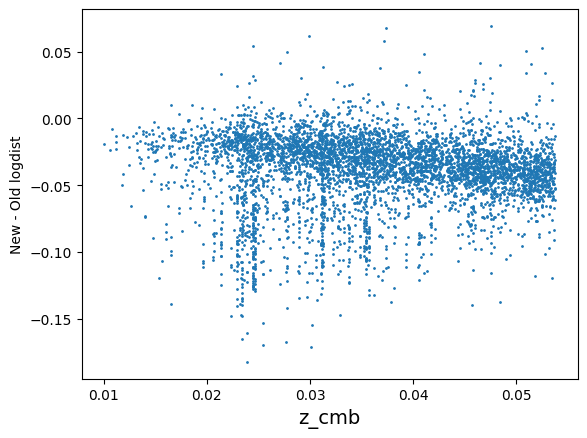

In [5]:
# Calculate logdist difference
df["delta_logdist"] = df["logdist_new_sdss"] - df["logdist_corr"]

# Plot vs redshift
plt.scatter(df["z_dist_est"], df["delta_logdist"], s=1)
plt.xlabel("z_cmb", fontsize=14)
plt.ylabel("New - Old logdist")

In [6]:
# Save
df.to_csv("./cullan_sdss_logdist_new.csv", index=False)

In [8]:
df


,PGC,coords,objid,specObjId,plate,ra,dec,l,b,deVMag_g,...,z_cosmo,lmin,lmax,logdist_pred,r_true,logdist_new_sdss,logdist_err_new_sdss,logdist_chisq_new_sdss,logdist_rmse_new_sdss,delta_logdist
0,2180626,J161531.4+412425,SDSS1237659329777107022,1318559404106213120,1171,243.880668,41.407020,65.575776,46.176954,15.44160,...,0.024920,1.021947,2.421947,0.024573,-0.15201,0.005483,0.087548,0.241463,0.005772,-0.022284
1,1202881,J120049.3+014137,SDSS1237651752936669345,581023484520458240,516,180.205594,1.693724,275.307612,61.820046,16.37174,...,0.049987,1.340491,2.740491,-0.001868,0.31751,-0.156836,0.098538,0.168158,0.004635,-0.055840
2,2390396,J121711.0+511256,SDSS1237658206121951256,1092266436388218752,970,184.296053,51.215516,135.708833,65.054699,16.24372,...,0.047959,1.323610,2.723610,-0.002416,0.52633,-0.134792,0.098388,0.228077,0.005459,-0.048371
3,25140,J085646.5+564712,SDSS1237651272963326121,504552173967796160,448,134.193871,56.786748,160.207295,39.420629,15.65960,...,0.026021,1.046898,2.446898,-0.003019,0.04861,-0.083716,0.089757,0.457909,0.008222,-0.021819
10,3564056,J151039.3+330750,SDSS1237662305657684247,1560580336289605632,1386,227.663761,33.130507,52.815995,59.450387,15.74019,...,0.047658,1.317129,2.717129,-0.002969,0.41717,-0.060585,0.095367,0.341394,0.006923,-0.037359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,2155907,J162858.8+394811,SDSS1237655471820701863,1319692450939299840,1172,247.245235,39.803056,63.284681,43.634451,15.95666,...,0.031450,1.127329,2.527329,-0.004408,0.46612,0.052966,0.091547,0.399805,0.007363,-0.107963
8893,56786,J160218.0+162158,SDSS1237665531723317440,2472613143914768384,2196,240.575050,16.366201,29.418294,44.669599,15.29424,...,0.040766,1.252066,2.652066,-0.016084,0.53285,-0.082195,0.094290,0.445787,0.008051,-0.016378
8894,58348,J162944.9+404842,SDSS1237655373573062713,919958120371873792,817,247.437155,40.811611,64.680181,43.506581,12.81371,...,0.027720,1.068212,2.468212,0.027133,0.86249,0.236139,0.085305,0.012186,0.001064,0.014576
8895,58191,J162741.1+405537,SDSS1237655472357114000,918822324826826880,816,246.921342,40.926966,64.835897,43.897452,13.70092,...,0.031610,1.126582,2.526582,-0.004386,0.87336,0.037454,0.088047,0.344019,0.007056,0.038341


# Recheck logdist comparison

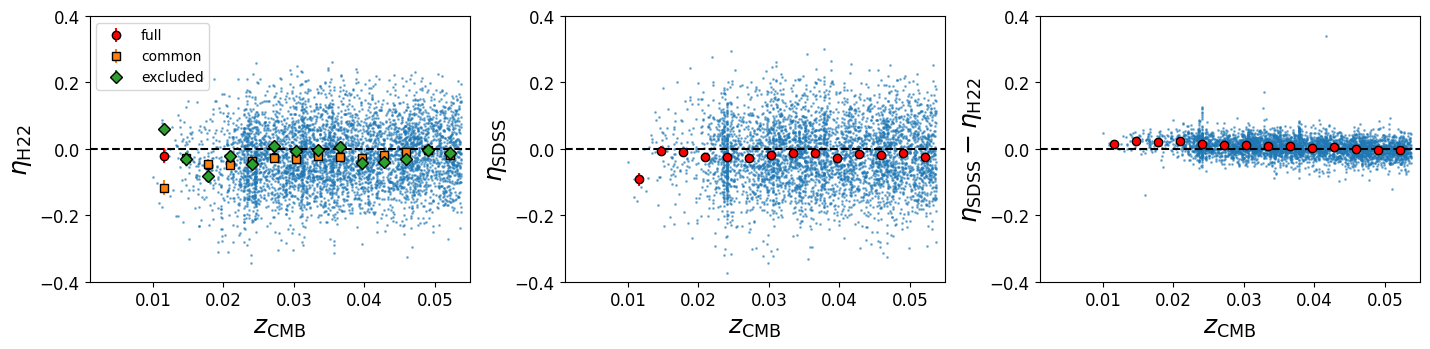

In [5]:
a_ = 1.8
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * a_, 2 * a_))
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{H22}$', '$\eta_\mathrm{SDSS}$', '$\eta_\mathrm{SDSS} - \eta_\mathrm{H22}$']

# Load my SDSS data
df_mine = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")

# Load Cullan's SDSS data
df_cullan = pd.read_csv("./cullan_sdss_logdist_new.csv")
df_cullan.rename({"z_dist_est": "zcmb_group"}, axis=1, inplace=True)

# Plot Cullan's data vs redshift
## Full redshift-limited sample
ax1.scatter(df_cullan['zcmb_group'], df_cullan['logdist_new_sdss'], s=1, alpha=0.5)
# z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cullan['zcmb_group'].to_numpy(), df_cullan['logdist_new_sdss'].to_numpy(), 
# n_bin=N_BIN, window_size=WINDOW_SIZE)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cullan['zcmb_group'].to_numpy(), df_cullan['logdist_new_sdss'].to_numpy(), xmin=ZMIN, xmax=ZMAX, n_bin=15)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['objid', 'z_dist_est', 'logdist_all_combined', 'logdist_err_all_combined']]\
    .merge(df_cullan[['objid', 'zcmb_group', 'logdist_new_sdss', 'logdist_err_new_sdss']], how='inner')
# z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_new_sdss'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_new_sdss'].to_numpy(), xmin=ZMIN, xmax=ZMAX, n_bin=15)
# ax1.scatter(df_common['zcmb_group'], df_common['logdist_new_sdss'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cullan[~(df_cullan['objid'].isin(df_common['objid'].tolist()))]
# z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_new_sdss'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_new_sdss'].to_numpy(), xmin=ZMIN, xmax=ZMAX, n_bin=15)
# ax1.scatter(df_excluded['zcmb_group'], df_excluded['logdist_new_sdss'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')
ax1.legend()


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_all_combined'].to_numpy(), xmin=ZMIN, xmax=ZMAX, n_bin=15)
ax2.scatter(df_mine['z_dist_est'], df_mine['logdist_all_combined'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_all_combined'] - df_common['logdist_new_sdss']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), xmin=ZMIN, xmax=ZMAX, n_bin=15)
ax3.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.001, 0.055)
    ax.set_ylim(-0.4, 0.4)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=18)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.tight_layout()
# fig.savefig('./sdss_comparison.pdf', bbox_inches='tight', dpi=300)